In [5]:
import os
import random
import numpy as np
import tensorflow as tf

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU 설정
gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE=224
BATCH_SIZE=32
DATA_PATH="../data/processed_224"

datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    zoom_range=0.05,
    brightness_range=[0.9, 1.1],
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED
)

Found 8032 images belonging to 2 classes.
Found 2007 images belonging to 2 classes.


In [7]:
print("클래스 인덱스:", train_generator.class_indices)

클래스 인덱스: {'Closed': 0, 'Opened': 1}


# MobileNetV2

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# base_model=MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
# base_model.trainable=False

# x=base_model.output
# x=GlobalAveragePooling2D()(x)
# x=Dropout(0.3)(x)
# output=Dense(1, activation="sigmoid")(x)

# model=Model(inputs=base_model.input, outputs=output)
# model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

# #model.summary()

In [16]:
# base_model 불러오기
base_model=MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# 전체 훈련 가능하게 설정한 후 일부만 활성화
base_model.trainable=True

# 일부 층만 fine-tune 
# 마지막 30개 층
fine_tune_at=len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable=False

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.3)(x)
output=Dense(1, activation="sigmoid")(x)

model=Model(inputs=base_model.input, outputs=output)

# 더 낮은 learning rate로 재컴파일
model.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

In [17]:
# checkpoint_path="../result/01_MobileNetV2_best_model.keras"
# os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
# esc=EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
# mcp=ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1)

In [18]:
checkpoint_path="../result/02_MobileNetV2_finetune_model.keras"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
esc=EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
mcp=ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1)

In [19]:
history=model.fit(train_generator, validation_data=val_generator,
                  epochs=20, callbacks=[esc, mcp], verbose=1)

Epoch 1/20
251/251 [==============================] - ETA: 0s - loss: 0.3842 - accuracy: 0.8364
Epoch 1: val_loss improved from inf to 0.23231, saving model to ../result/02_MobileNetV2_finetune_model.keras
251/251 [==============================] - 56s 200ms/step - loss: 0.3842 - accuracy: 0.8364 - val_loss: 0.2323 - val_accuracy: 0.9297
Epoch 2/20
251/251 [==============================] - ETA: 0s - loss: 0.1875 - accuracy: 0.9326
Epoch 2: val_loss improved from 0.23231 to 0.21335, saving model to ../result/02_MobileNetV2_finetune_model.keras
251/251 [==============================] - 49s 196ms/step - loss: 0.1875 - accuracy: 0.9326 - val_loss: 0.2133 - val_accuracy: 0.9327
Epoch 3/20
251/251 [==============================] - ETA: 0s - loss: 0.1650 - accuracy: 0.9419
Epoch 3: val_loss did not improve from 0.21335
251/251 [==============================] - 48s 191ms/step - loss: 0.1650 - accuracy: 0.9419 - val_loss: 0.2254 - val_accuracy: 0.9337
Epoch 4/20
251/251 [===================

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

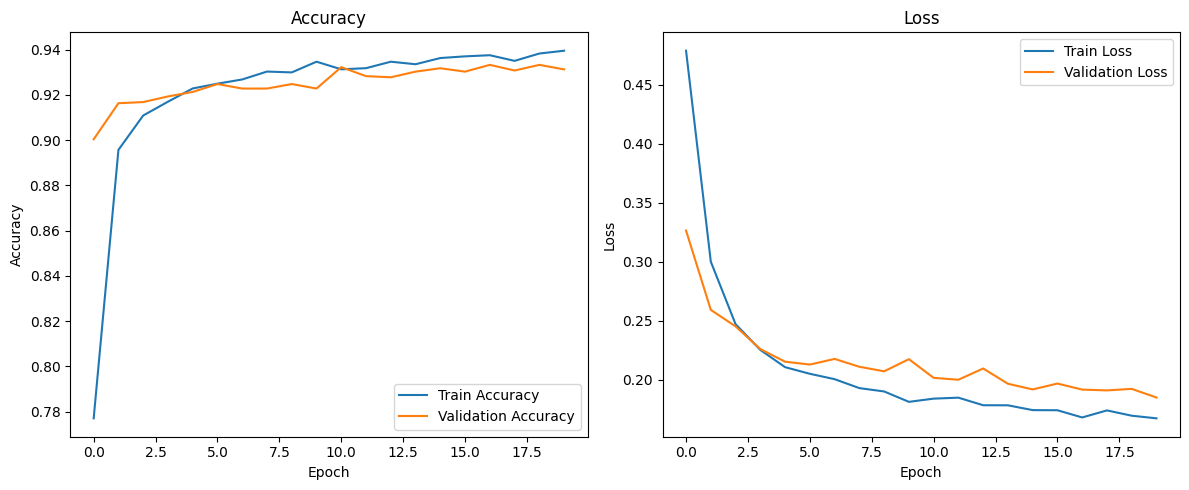

In [ ]:
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history.history["accuracy"], label="Train Accuracy")
# plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
# plt.title("Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history["loss"], label="Train Loss")
# plt.plot(history.history["val_loss"], label="Validation Loss")
# plt.title("Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()

# plt.tight_layout()
# plt.savefig("../result/01_MobileNetV2_training_plot.png")
# plt.show()

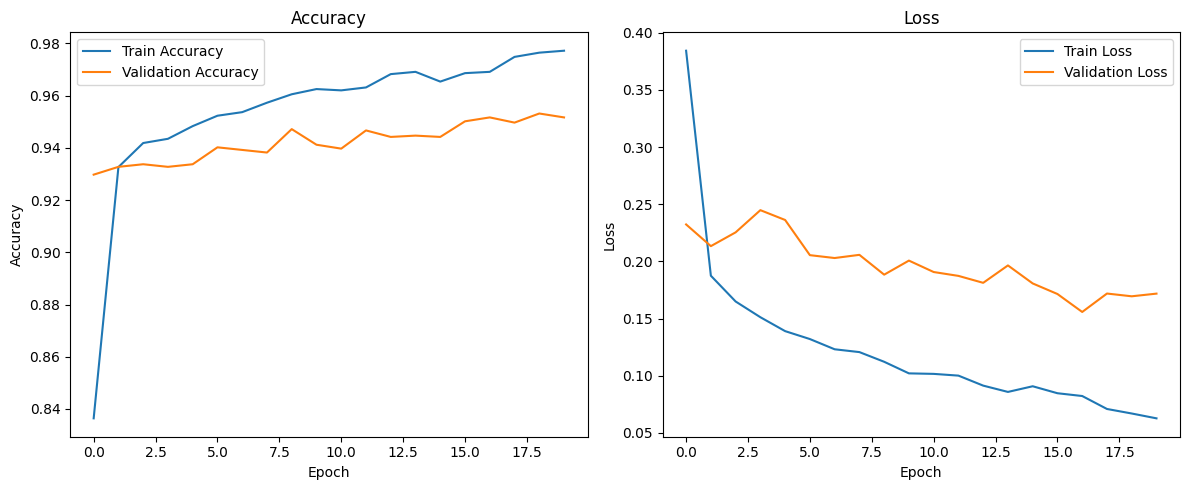

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../result/02_MobileNetV2_finetune_training_plot.png")
plt.show()

In [ ]:
# y_true=val_generator.classes
# steps=val_generator.samples // val_generator.batch_size + 1
# y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
# y_pred=(y_pred_prob > 0.5).astype(int)

# report=classification_report(y_true, y_pred, target_names=["Closed", "Opened"])
# print("=== Classification Report ===")
# print(report)

# with open("../result/01_MobileNetV2_classification_report.txt", "w") as f:
#     f.write(report)

=== Classification Report ===
              precision    recall  f1-score   support

      Closed       0.89      0.99      0.94      1000
      Opened       0.99      0.88      0.93      1007

    accuracy                           0.93      2007
   macro avg       0.94      0.93      0.93      2007
weighted avg       0.94      0.93      0.93      2007



In [22]:
y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

report=classification_report(y_true, y_pred, target_names=["Closed", "Opened"])
print("=== Classification Report ===")
print(report)

with open("../result/02_MobileNetV2_finetune_classification_report.txt", "w") as f:
    f.write(report)

=== Classification Report ===
              precision    recall  f1-score   support

      Closed       0.91      1.00      0.95      1000
      Opened       1.00      0.90      0.95      1007

    accuracy                           0.95      2007
   macro avg       0.95      0.95      0.95      2007
weighted avg       0.95      0.95      0.95      2007



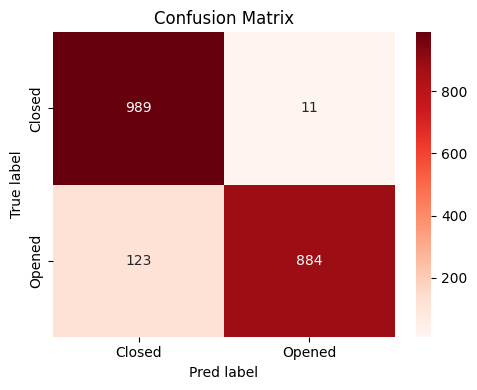

In [ ]:
# conf_matrix=confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(5, 4))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
#             xticklabels=["Closed", "Opened"], yticklabels=["Closed", "Opened"])
# plt.title("Confusion Matrix")
# plt.xlabel("Pred label")
# plt.ylabel("True label")
# plt.tight_layout()

# plt.savefig("../result/01_MobileNetV2_confusion_matrix.png")
# plt.show()

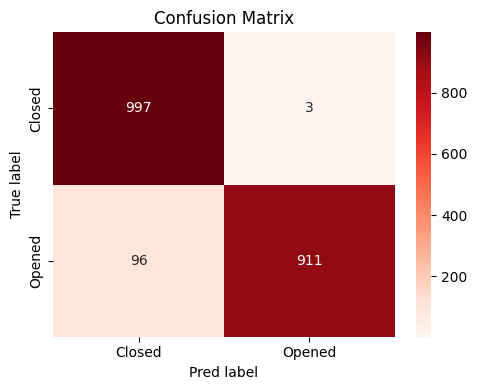

In [23]:
conf_matrix=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Closed", "Opened"], yticklabels=["Closed", "Opened"])
plt.title("Confusion Matrix")
plt.xlabel("Pred label")
plt.ylabel("True label")
plt.tight_layout()

plt.savefig("../result/02_MobileNetV2_finetune_confusion_matrix.png")
plt.show()

In [24]:
model.save("../result/model.keras")
model.save("../result/model.h5")

/home/julianjeong/miniconda3/envs/WSL_CUDA_TF01/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
